## Import Libraries ##

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore') 

## Load the dataset ##

In [5]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        labels.append(label.lower())
    if len(paths)==2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


## Create Dataframe ##

In [6]:
#Create a dataframe
df=pd.DataFrame()
df['audio_paths']=paths
df['labels']=labels
df.head()

,audio_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [7]:
df['labels'].value_counts()

labels
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

## Visualize Data ##

<Axes: xlabel='labels', ylabel='count'>

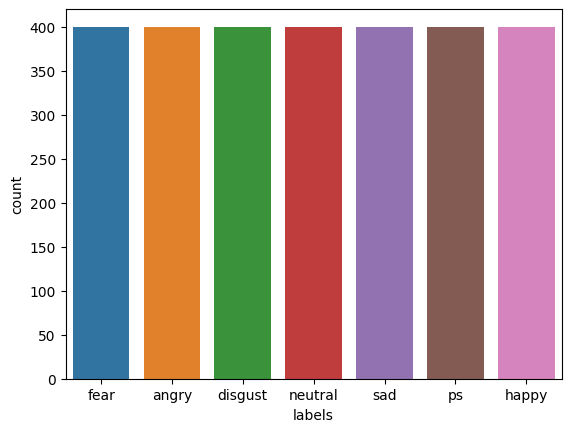

In [8]:
sns.countplot(data=df, x='labels')

## Plot Waveplot and Spectogram ##

In [9]:
#Amplitude of sound
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
#frequency of sound
def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

## Load and Visualize Example Audios ##

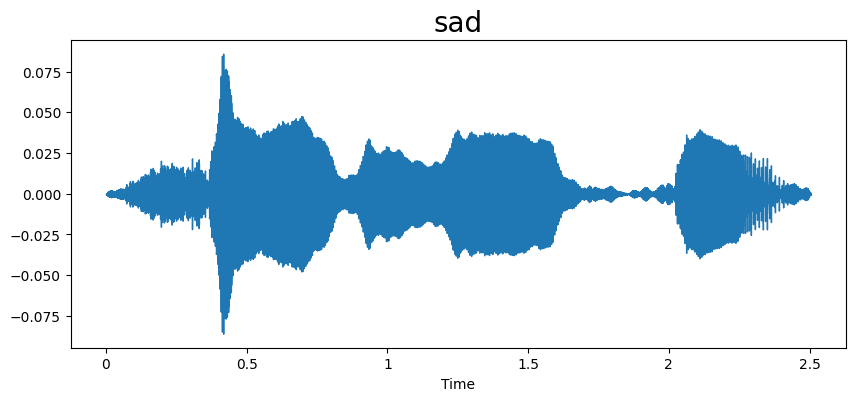

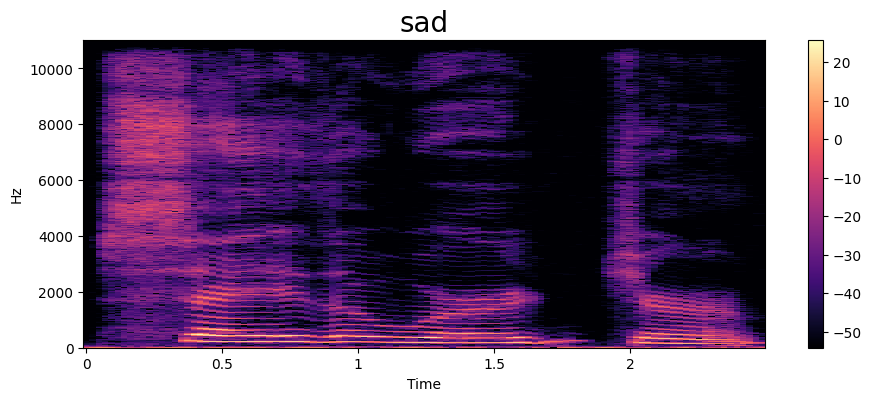

In [17]:
emotion='sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

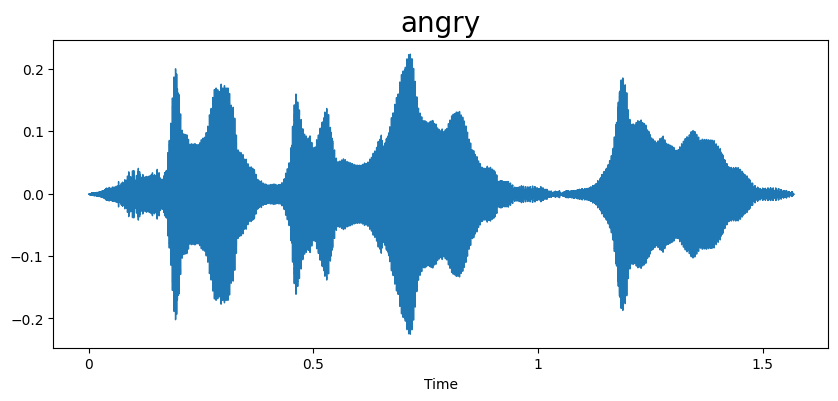

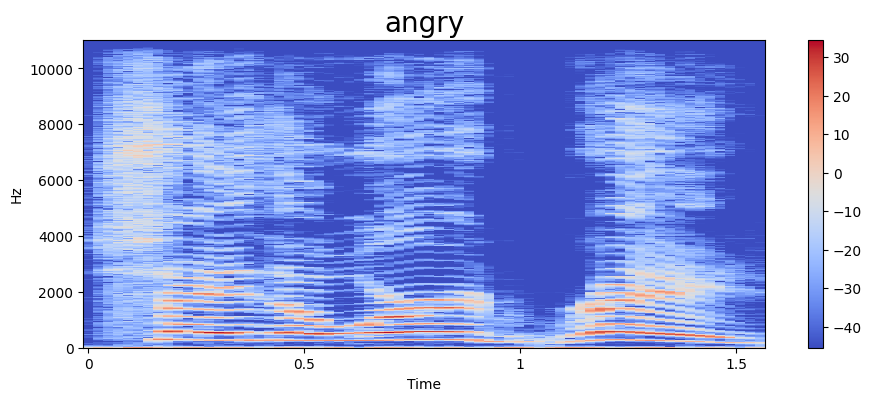

In [8]:
emotion='angry'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

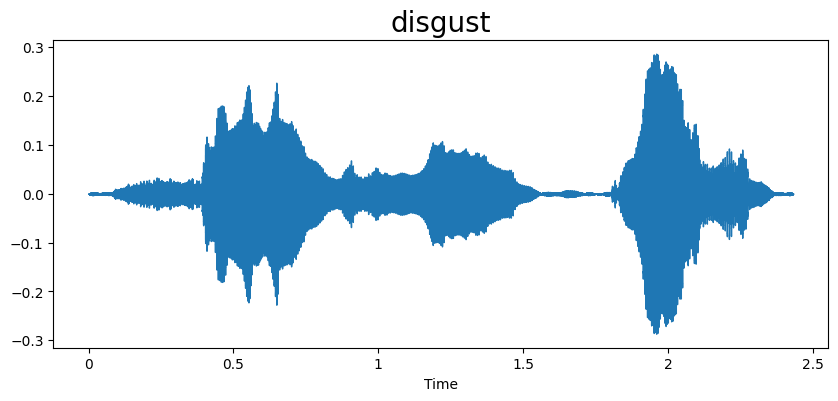

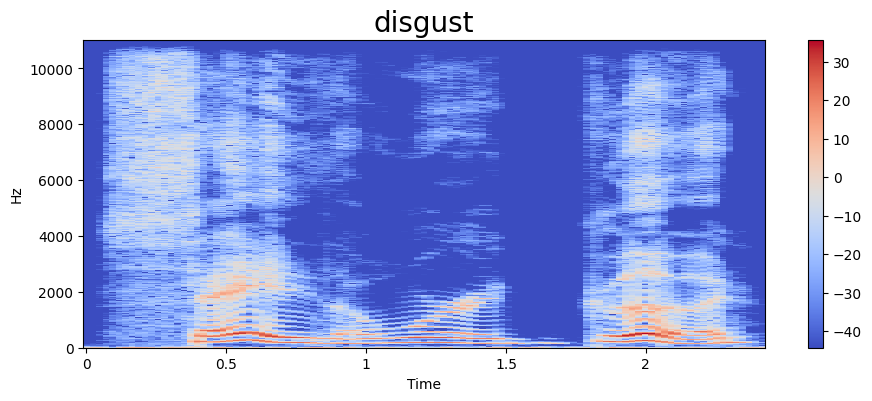

In [9]:
emotion='disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

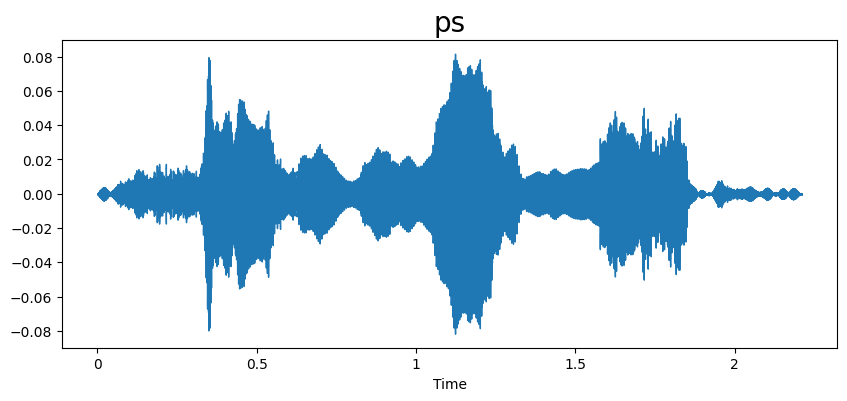

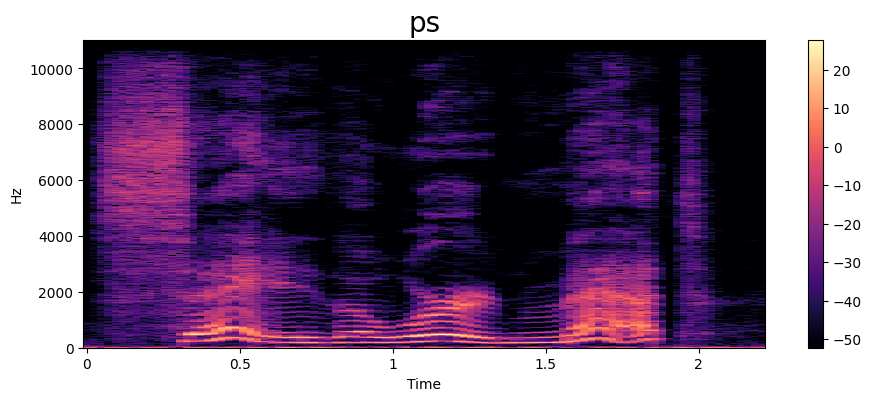

In [10]:
emotion='ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

## Map Labels to Integers ##

In [103]:
#convert labels to Integers
label_map={label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map={idx : label for label, idx in label_map.items()}
df['labels']=df['labels'].map(label_map)
df.head(2)



,audio_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,0
1,/kaggle/input/toronto-emotional-speech-set-tes...,0


 ##  Define Custom Dataset Class ## 

In [12]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):# 2 seconds of audio at 16 kHz = 32000 samples
        self.df=df
        self.processor=processor
        self.max_length=max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path=self.df.iloc[idx]['audio_paths']
        label=self.df.iloc[idx]['labels']

        #load the audio file
        speech, sr =librosa.load(audio_path, sr=16000)
        
        #truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech=np.pad(speech, (0, self.max_length - len(speech)),'constant')

        #preprocess the audio file
        inputs=self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)
        input_values=inputs.input_values.squeeze()
        return{'input_values' : input_values, 'labels':torch.tensor(label, dtype=torch.long)}
         

## Split Dataset ##

In [13]:
#split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Load Pre-Trained Model ##

In [14]:
# Path to the directory where the files are stored
local_path = '/kaggle/input/zipfile/'

# Load the processor and model from the local path
processor = Wav2Vec2Processor.from_pretrained(local_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(local_path, num_labels=7)

In [15]:
#load the dataset
train_dataset= SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [16]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

## Train the Model ##

In [17]:
training_args=TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [18]:
#create function for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels=pred.label_ids #original labels
    preds=np.argmax(pred.predictions, axis=1) #model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _=precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [20]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.049589,1.000000,1.000000,1.000000,1.000000
2,No log,0.028801,1.000000,1.000000,1.000000,1.000000
3,No log,0.024392,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.0612569945199149, metrics={'train_runtime': 7204.851, 'train_samples_per_second': 0.933, 'train_steps_per_second': 0.058, 'total_flos': 1.2201848064e+17, 'train_loss': 0.0612569945199149, 'epoch': 3.0})

## Evaluate the Model ## 

In [ ]:
results=trainer.evaluate()
print(results)

## Predict a Random Sample ##

In [22]:
import random
idx=random.randrange(0, len(test_dataset))
print('Original label:', inverse_label_map[int(test_dataset[idx]['labels'])])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)
with torch.no_grad():
    outputs=model(input_values)
logits=outputs.logits
predicted_class=logits.argmax(dim=-1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original label: disgust
Predicted Label: disgust


In [23]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [24]:
idx=random.randrange(0, len(test_dataset))
print('Original label:', inverse_label_map[int(test_dataset[idx]['labels'])])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)
with torch.no_grad():
    outputs=model(input_values)
logits=outputs.logits
predicted_class=logits.argmax(dim=-1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original label: fear
Predicted Label: fear


In [25]:
idx=random.randrange(0, len(test_dataset))
print('Original label:', inverse_label_map[int(test_dataset[idx]['labels'])])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)
with torch.no_grad():
    outputs=model(input_values)
logits=outputs.logits
predicted_class=logits.argmax(dim=-1).item()
print('Predicted Label:', inverse_label_map[predicted_class])

Original label: disgust
Predicted Label: disgust


## Predict a New File ##

In [80]:
import soundfile as sf
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Load the processor and model from the local path (or online path if preferred)
local_path = '/kaggle/input/zipfile/'
processor = Wav2Vec2Processor.from_pretrained(local_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(local_path, num_labels=7)

# Load the label map to get label names
inverse_label_map = {0: 'fear', 1: 'ps', 2: 'sad', 3: 'angry', 4: 'disgust', 5: 'happy', 6: 'neutral'}

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to load the audio file
def load_audio(file_path, sampling_rate=16000):
    """
    Loads an audio file using soundfile.
    :param file_path: Path to the audio file
    :param sampling_rate: Target sampling rate
    :return: Numpy array of audio data
    """
    print(f"Loading audio file: {file_path}")
    audio, sr = sf.read(file_path)
    if sr != sampling_rate:
        print(f"Resampling from {sr} to {sampling_rate} Hz")
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sampling_rate)
    audio = audio.squeeze()
    print("Audio loaded successfully.")
    return audio

# Function to predict the emotion of the audio
def predict_emotion(audio, sampling_rate=16000):
    max_length = 32000  # 2 seconds of audio at 16 kHz = 32000 samples
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')
    
    # Process the audio using Wav2Vec2Processor
    inputs = processor(audio, sampling_rate=sampling_rate, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    input_values = inputs.input_values.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    
    return inverse_label_map[predicted_class]

# Predict from a pre-recorded file
file_path = '/kaggle/input/audiofile/WhatsApp Audio 2024-12-11 at 12.19.42 PM.wav'  # Replace with the path to your file
audio = load_audio(file_path)
predicted_emotion = predict_emotion(audio)
print(f"Predicted Emotion: 🎉 {predicted_emotion.upper()} 🎉")


Loading audio file: /kaggle/input/audiofile/WhatsApp Audio 2024-12-11 at 12.19.42 PM.wav
Resampling from 48000 to 16000 Hz
Audio loaded successfully.
Predicted Emotion: 🎉 HAPPY 🎉


In [16]:
import soundfile as sf
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Load the processor and model from the local path (or online path if preferred)
local_path = '/kaggle/input/zipfile/'
processor = Wav2Vec2Processor.from_pretrained(local_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(local_path, num_labels=7)

# Load the label map to get label names
inverse_label_map = {0: 'fear', 1: 'angry', 2: 'disgust', 3: 'neutral', 4: 'sad', 5: 'happy', 6: 'ps'}

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to load the audio file
def load_audio(file_path, sampling_rate=16000):
    """
    Loads an audio file using soundfile.
    :param file_path: Path to the audio file
    :param sampling_rate: Target sampling rate
    :return: Numpy array of audio data
    """
    print(f"Loading audio file: {file_path}")
    audio, sr = sf.read(file_path)
    if sr != sampling_rate:
        print(f"Resampling from {sr} to {sampling_rate} Hz")
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sampling_rate)
    audio = audio.squeeze()
    print("Audio loaded successfully.")
    return audio

# Function to predict the emotion of the audio
def predict_emotion(audio, sampling_rate=16000):
    max_length = 32000  # 2 seconds of audio at 16 kHz = 32000 samples
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')
    
    # Process the audio using Wav2Vec2Processor
    inputs = processor(audio, sampling_rate=sampling_rate, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    input_values = inputs.input_values.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    
    return inverse_label_map[predicted_class]



# Predict from a pre-recorded file
file_path = '/kaggle/input/aashritha1/record_out.wav'  # Replace with the path to your file
audio = load_audio(file_path)
predicted_emotion = predict_emotion(audio)
print(f"Predicted Emotion: 🎉 {predicted_emotion.upper()} 🎉")


Loading audio file: /kaggle/input/aashritha1/record_out.wav
Resampling from 48000 to 16000 Hz
Audio loaded successfully.
Predicted Emotion: 🎉 HAPPY 🎉


In [ ]:

import soundfile as sf
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Load the processor and model from the local path (or online path if preferred)
local_path = '/kaggle/input/zipfile/'
processor = Wav2Vec2Processor.from_pretrained(local_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(local_path, num_labels=7)

# Load the label map to get label names
inverse_label_map = {0: 'neutral', 1: 'happy', 2: 'sad', 3: 'angry', 4: 'fear', 5: 'disgust', 6: 'surprise'}

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to load the audio file
def load_audio(file_path, sampling_rate=16000):
    """
    Loads an audio file using soundfile.
    :param file_path: Path to the audio file
    :param sampling_rate: Target sampling rate
    :return: Numpy array of audio data
    """
    print(f"Loading audio file: {file_path}")
    audio, sr = sf.read(file_path)
    if sr != sampling_rate:
        print(f"Resampling from {sr} to {sampling_rate} Hz")
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sampling_rate)
    audio = audio.squeeze()
    print("Audio loaded successfully.")
    return audio

# Function to predict the emotion of the audio
def predict_emotion(audio, sampling_rate=16000):
    max_length = 32000  # 2 seconds of audio at 16 kHz = 32000 samples
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')
    
    # Process the audio using Wav2Vec2Processor
    inputs = processor(audio, sampling_rate=sampling_rate, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    input_values = inputs.input_values.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    
    return inverse_label_map[predicted_class]

# Predict from a pre-recorded file
file_path = '/path/to/your/audio.wav'  # Replace with the path to your file
audio = load_audio(file_path)
predicted_emotion = predict_emotion(audio)
print(f"Predicted Emotion: 🎉 {predicted_emotion.upper()} 🎉")

In [18]:

import soundfile as sf
import torch
import librosa
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Load the processor and model from the local path (or online path if preferred)
local_path = '/kaggle/input/zipfile/'
processor = Wav2Vec2Processor.from_pretrained(local_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(local_path, num_labels=7)

# Load the label map to get label names
inverse_label_map = {0: 'neutral', 1: 'happy', 2: 'sad', 3: 'angry', 4: 'fear', 5: 'disgust', 6: 'surprise'}

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to load the audio file
def load_audio(file_path, sampling_rate=16000):
    """
    Loads an audio file using soundfile.
    :param file_path: Path to the audio file
    :param sampling_rate: Target sampling rate
    :return: Numpy array of audio data
    """
    print(f"Loading audio file: {file_path}")
    audio, sr = sf.read(file_path)
    if sr != sampling_rate:
        print(f"Resampling from {sr} to {sampling_rate} Hz")
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sampling_rate)
    audio = audio.squeeze()
    print("Audio loaded successfully.")
    return audio

# Function to predict the emotion of the audio
def predict_emotion(audio, sampling_rate=16000):
    max_length = 32000  # 2 seconds of audio at 16 kHz = 32000 samples
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')
    
    # Process the audio using Wav2Vec2Processor
    inputs = processor(audio, sampling_rate=sampling_rate, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    input_values = inputs.input_values.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(input_values)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=-1).item()
    
    return inverse_label_map[predicted_class]

# Predict from a pre-recorded file
file_path = '/kaggle/input/ashritha/record_out (1).wav'  # Replace with the path to your file
audio = load_audio(file_path)
predicted_emotion = predict_emotion(audio)
print(f"Predicted Emotion: 🎉 {predicted_emotion.upper()} 🎉")

Loading audio file: /kaggle/input/ashritha-sad/record_out (1).wav
Resampling from 48000 to 16000 Hz
Audio loaded successfully.
Predicted Emotion: 🎉 FEAR 🎉
